In [44]:
# Install packages if needed

# install.packages('tensor')
install.packages('RSpectra')

Warning message in install.packages("RSpectra"):
“installation of package ‘RSpectra’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [45]:

library(cubature)
library(MASS)
library(pracma)
library(mvtnorm)

library(LogConcDEAD)
library(logcondens) 
library(mclust)
library(tensor)
library(RSpectra)

In [2]:
source('lcic.r')

In [47]:
# sessionInfo()

# Implement Samworth and Yuan (2012)

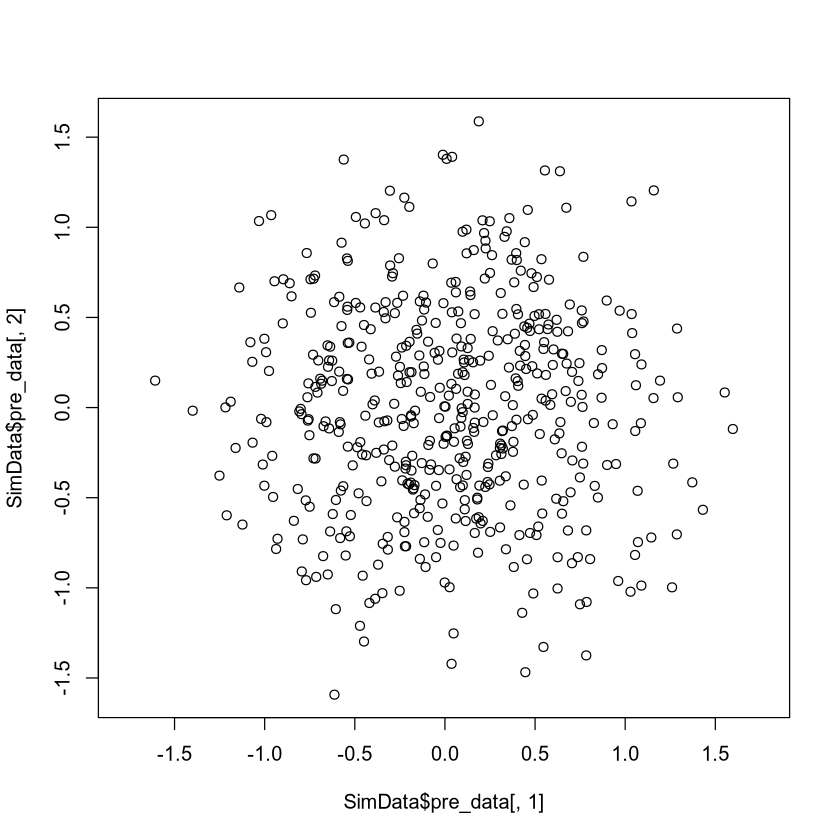

In [186]:

d = 8
n = 500
true_mean_vec <- rep(0,d) 
scalings_vec = rep(1, d)

SimData <- get_uniform_data(d, n, true_mean_vec, scalings_vec=scalings_vec)

plot(x=SimData$pre_data[,1], y=SimData$pre_data[,2], asp=1)


In [29]:
W_guess = fix_signs_fun(randortho(d, type="orthonormal"))

# W_guess - SimData$W

my_oracle_estimator <- fit_marginals_given_W(SimData, W_guess, plotting=FALSE)

[1] "Marginal: "
[1] 1
[1] "Marginal: "
[1] 2


In [30]:
W_guess

0.9903762,-0.1384017
0.1384017,0.9903762


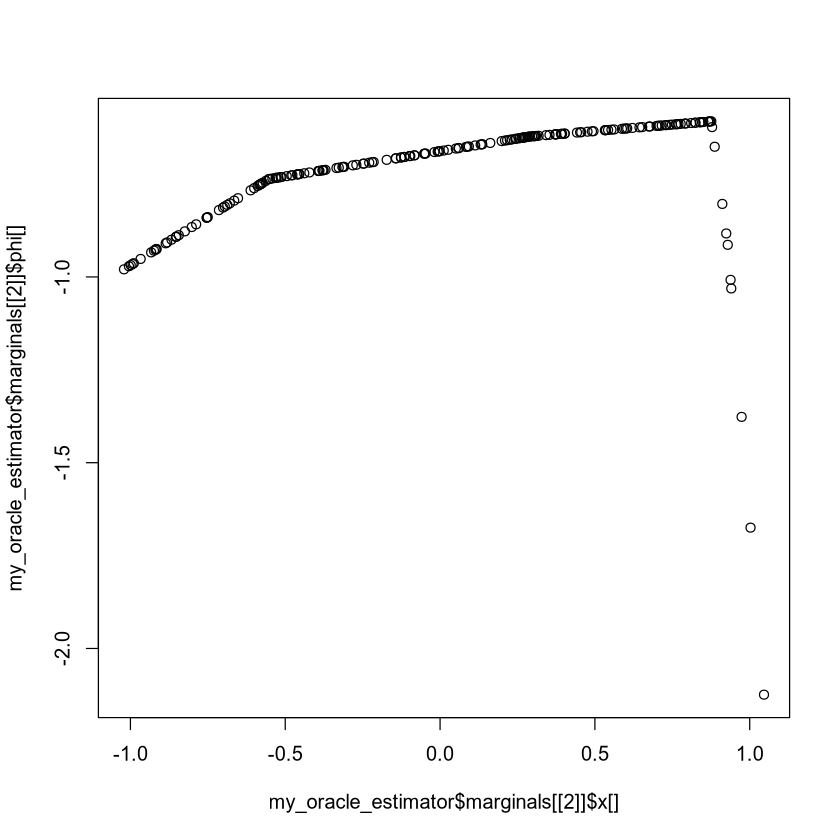

In [84]:
# print(my_oracle_estimator$marginals[[1]]$phi)
# length(my_oracle_estimator$marginals[[1]]$phi)
# plot(my_oracle_estimator$marginals[[1]]$phi)

# res <- my_oracle_estimator$marginals[[1]]
# plot(diff(res$phi) / diff(res$x))
# plot(my_oracle_estimator$marginals[[1]]$IsKnot)
# my_oracle_estimator$marginals[[1]]$x[mask] == my_oracle_estimator$marginals[[1]]$knots
mask <- (my_oracle_estimator$marginals[[1]]$IsKnot == 1)
plot(my_oracle_estimator$marginals[[2]]$x[], my_oracle_estimator$marginals[[2]]$phi[])
# plot(my_oracle_estimator$marginals[[1]]$x, my_oracle_estimator$marginals[[1]]$phi)

In [32]:
density <- my_oracle_estimator$marginals[[1]]
cumsum_knots <- cumsum(density$IsKnot)
cumsum_knots


[1] 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 [38] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 [75] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[112] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4
[149] 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
[186] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6

In [65]:
density$phi[mask]

[1] -3.7256430 -1.4569944 -1.2437352 -0.5190033 -0.4135093 -0.4379070 -1.1219423
[8] -2.6534287

In [64]:
diff(density$phi[mask])/diff(density$x[mask])

[1]  7.4062100  4.4013913  1.3340393  0.5584086 -0.1427650 -0.7270086 -4.3103295

In [69]:
my_oracle_estimator$marginals[[2]]$xn == my_oracle_estimator$marginals[[2]]$x 

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [16] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [31] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [46] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [61] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [76] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [91] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[106] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[121] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[136] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[151] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[166] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[181] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[196] TRUE TRUE TRUE TRUE TRUE

In [133]:
compute_directional_derivative <- function(Y_tst, SimData, W_current, estimator_current) {
    n <- SimData$n
    d <- SimData$d

    K_inds = matrix(0, nrow=n, ncol=d) # K_ij
    slopes_b = matrix(0, nrow=n, ncol=d)

    WY <- W_current %*% Y_tst
    grad_g_val <- 0

    for (dind in 1:d) {
        density <- estimator_current$marginals[[dind]]
        sample_sorting_indices <- estimator_current$sample_sorting_indices[[dind]]
        sorted_samples <- SimData$pre_data[sample_sorting_indices, ]
        mask <- (density$IsKnot == 1)
        cumsum_knots <- cumsum(density$IsKnot)
        slopes_knotwise <- diff(density$phi[mask])/diff(density$x[mask])
        
        num_knots <- sum(mask)
        knot_indices <- which(mask)
        c_vec <- WY[dind,]
        transformed_samples <- sorted_samples %*% c_vec
        selection_indicators <- transformed_samples[mask] 

        K_inds[,dind] = cumsum_knots # handles most points correctly
        K_inds[knot_indices, dind] <- ifelse(selection_indicators<0, c(1:num_knots)-1, c(1:num_knots)) # corrects the knot points

        K_inds[1, dind] <- 1
        K_inds[n, dind] <- num_knots - 1 # corrects the first and the last knot points

        slopes_b[,dind] <- slopes_knotwise[K_inds[,dind]]

        grad_g_val <- grad_g_val + sum(transformed_samples*slopes_b[,dind])/n
    }
    return(grad_g_val)
}

compute_normalized_log_likelihood_g <- function(SimData, W_candidate, estimator_current) {

    g_val <- 0

    Z_mat_candidate <- SimData$pre_data %*% t(W_candidate)

    for (dind in 1:SimData$d) {
        
        g_val <- g_val + (1/SimData$n)*sum(evaluateLogConDens(Z_mat_candidate[,dind], estimator_current$marginals[[dind]], which=1)[,2])
    }
    return(g_val)
}

update_W_given_marginals <- function(SimData, W_current, estimator_current, alp=0.3, gmm=0.5) {

    # Find steepest descent along the basis of the tangent space
    Y_tst <- matrix(0, nrow=SimData$d, ncol=SimData$d)
    grad_g_vals <- matrix(0, nrow=SimData$d, ncol=SimData$d)

    for (s in 1:(SimData$d - 1)){
        for (r in (s+1):SimData$d) {
            Y_tst[r,s] <- 1/sqrt(2)
            Y_tst[s,r] <- -1/sqrt(2)
            grad_g_vals[r,s] <- compute_directional_derivative(Y_tst, SimData, W_current, estimator_current)
            grad_g_vals[s,r] <- compute_directional_derivative(-Y_tst, SimData, W_current, estimator_current)
            Y_tst[r,s] <- 0
            Y_tst[s,r] <- 0
        }
    }
    grad_g_max <- max(grad_g_vals)
    max_inds <- which(grad_g_vals == grad_g_max, arr.ind = TRUE)
    r_max <- max_inds[1,1]
    s_max <- max_inds[1,2]

    # Construct Y_max
    Y_max <- matrix(0, nrow=SimData$d, ncol=SimData$d)
    Y_max[r_max,s_max] <- 1/sqrt(2)
    Y_max[s_max, r_max] <- -1/sqrt(2)

    # Line search
    ep <- 1.0
    W_candidate_update <- W_current %*% expm(ep*Y_max)
    g_val_current <- compute_normalized_log_likelihood_g(SimData, W_current, estimator_current)
    g_val_update <- compute_normalized_log_likelihood_g(SimData, W_candidate_update, estimator_current)
    counter <- 0
    while (g_val_update <= g_val_current + alp*ep*grad_g_max) {
        ep <- gmm*ep
        W_candidate_update <- W_current %*% expm(ep*Y_max)
        g_val_update <- compute_normalized_log_likelihood_g(SimData, W_candidate_update, estimator_current)
        counter <- counter + 1
        if (counter > 20) break
    }  
    return(W_candidate_update)
}

-0.2459794,0.05056491,0.96795524
0.3458449,0.93748440,0.03891389
-0.9054753,0.34433442,-0.24808944


[1] "Marginal: "
[1] 1
[1] "Marginal: "
[1] 2
[1] "Marginal: "
[1] 3
[1] "Iter: "
[1] 1


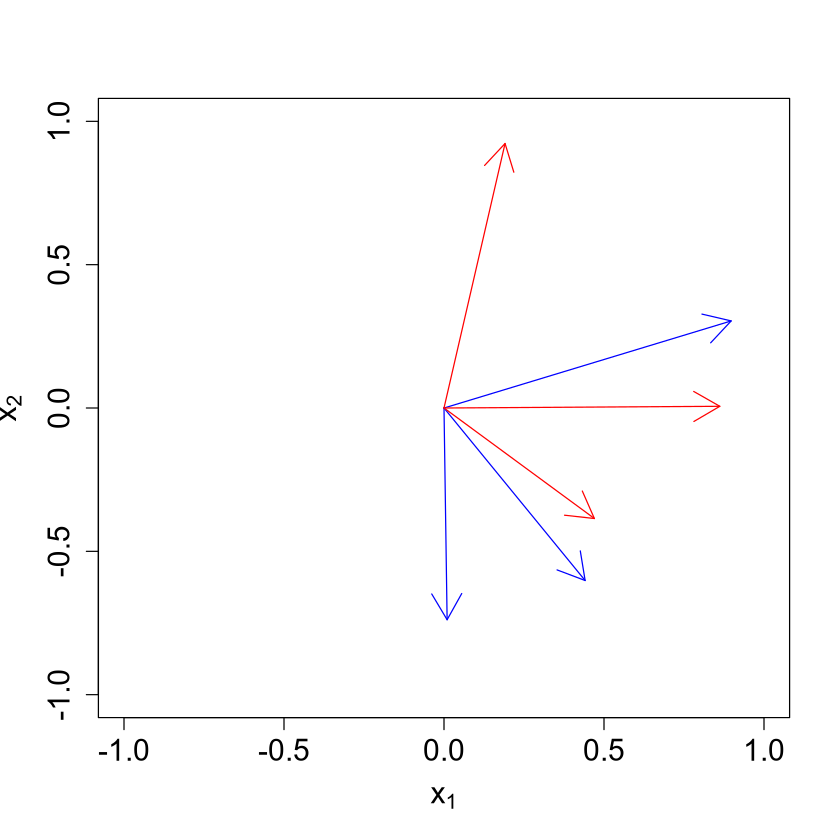

[1] "Marginal: "
[1] 1
[1] "Marginal: "
[1] 2
[1] "Marginal: "
[1] 3
[1] "Iter: "
[1] 2


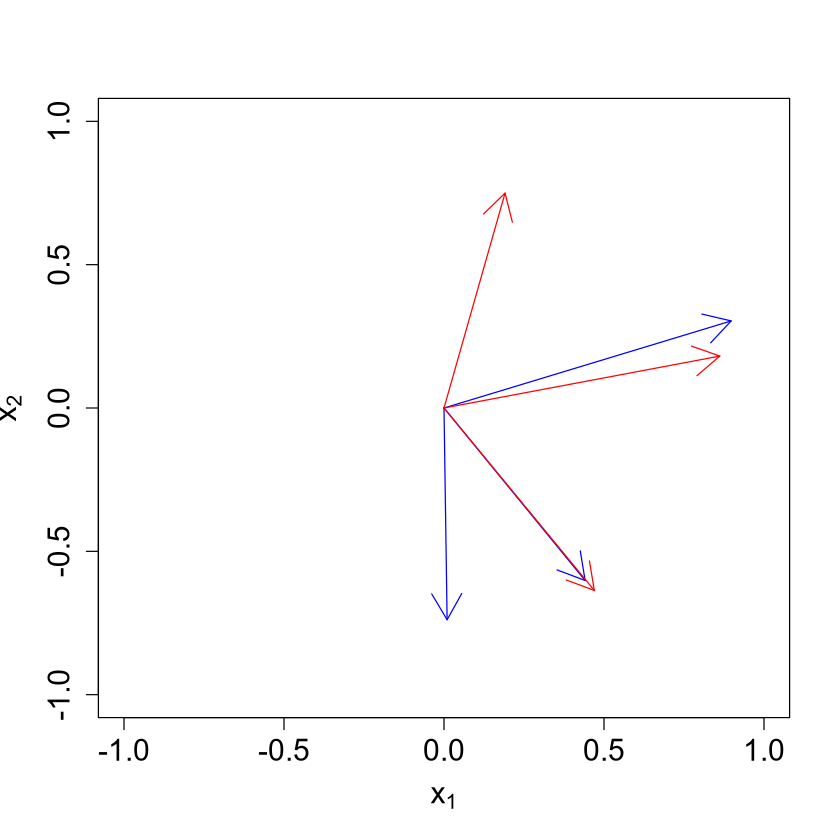

[1] "Marginal: "
[1] 1
[1] "Marginal: "
[1] 2
[1] "Marginal: "
[1] 3
[1] "Iter: "
[1] 3


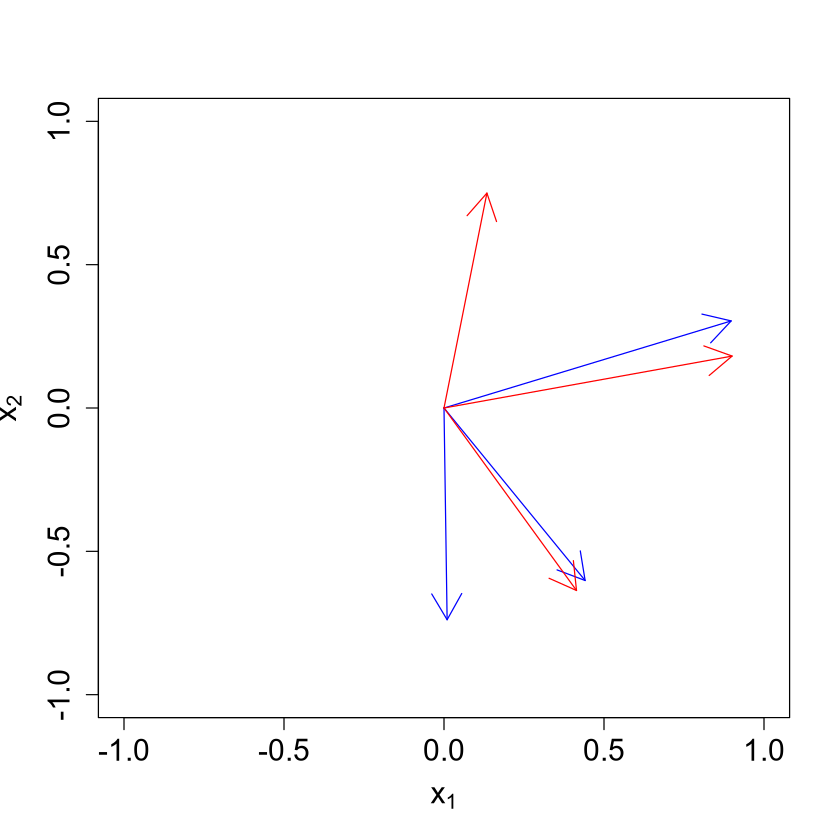

[1] "Marginal: "
[1] 1
[1] "Marginal: "
[1] 2
[1] "Marginal: "
[1] 3
[1] "Iter: "
[1] 4


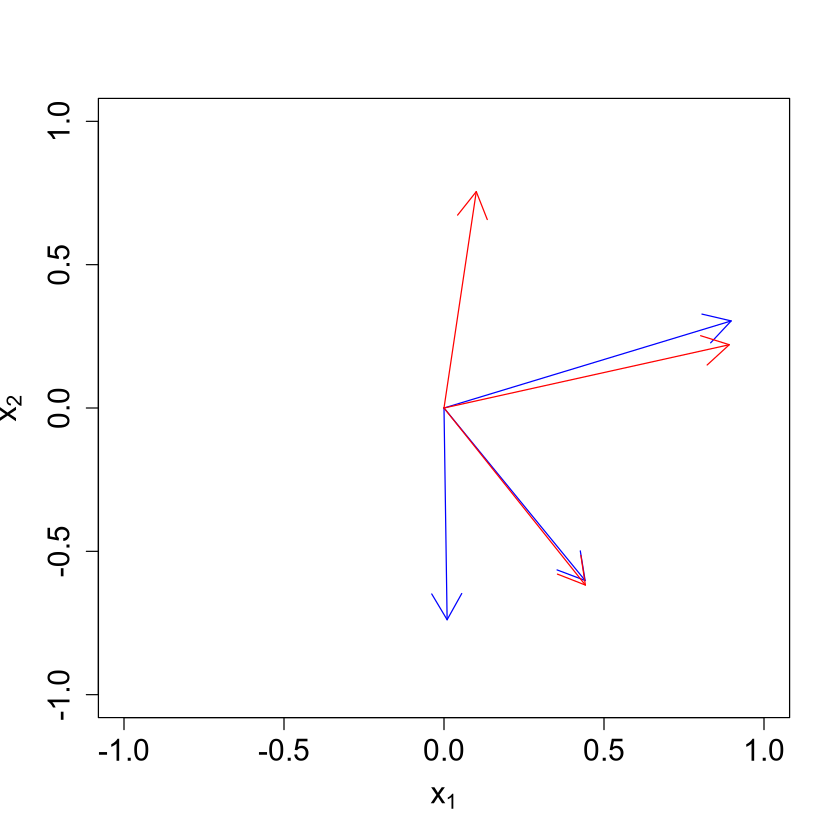

[1] "Marginal: "
[1] 1
[1] "Marginal: "
[1] 2
[1] "Marginal: "
[1] 3
[1] "Iter: "
[1] 5


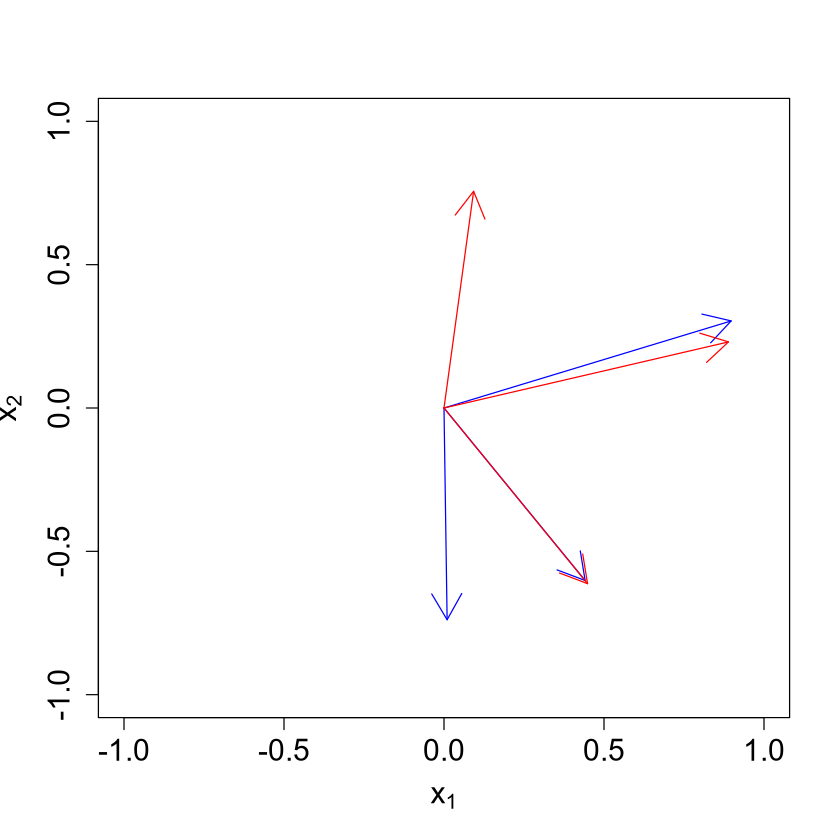

            [,1]        [,2]        [,3]
[1,]  0.01839906 0.008315641  0.99979614
[2,]  0.10512937 0.994406218 -0.01020544
[3,] -0.99428833 0.105295735  0.01742190


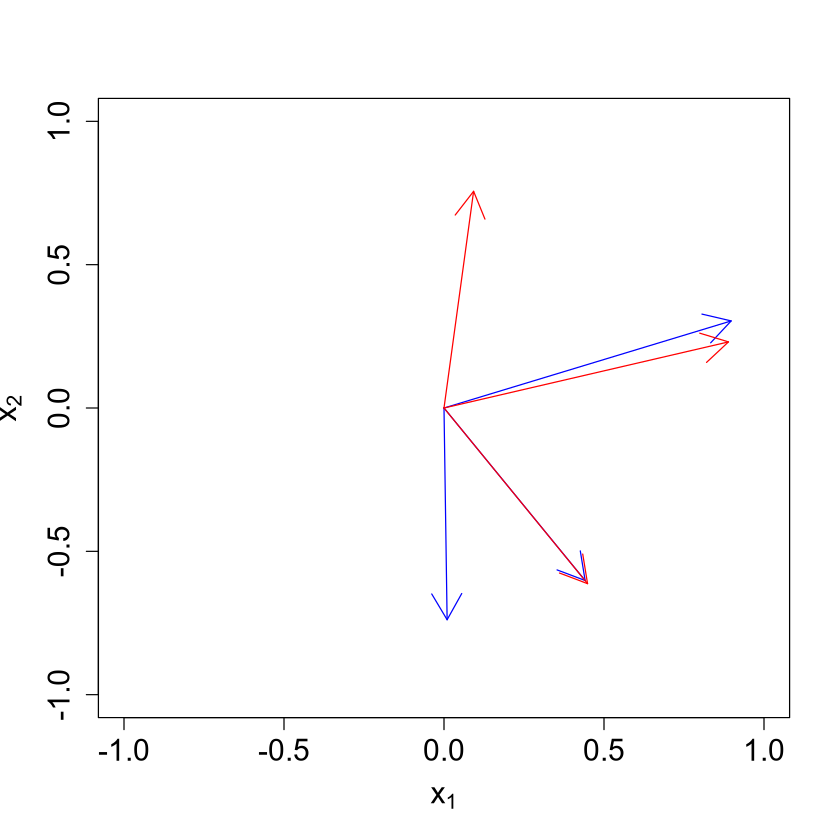

In [134]:
# Algorithm trial

W_current = fix_signs_fun(randortho(d, type="orthonormal"))
visualize_independent_directions_from_W(SimData$W, W_current)

num_iter <- 5

for (itind in 1:num_iter) {
    
    estimator_current <- fit_marginals_given_W(SimData, W_current, plotting=FALSE)

    W_current <- update_W_given_marginals(SimData, W_current, estimator_current, alp=0.3, gmm=0.5)

    print("Iter: ")
    print(itind)
    visualize_independent_directions_from_W(SimData$W, W_current)

}
print(W_current %*% t(SimData$W))




In [131]:
W_current %*% t(SimData$W)

0.223689227,0.9745645,0.01367409
0.008261452,-0.0159249,0.99983899
-0.974625443,0.2235403,0.01161352


In [114]:
# grad_g_val
Z_mat_candidate <- SimData$pre_data %*% t(W_guess)
print(evaluateLogConDens(Z_mat_candidate[,1], my_oracle_estimator$marginals[[1]], which=1)[,2])

  [1] -0.7741638 -1.0802363 -0.7871267 -0.6390728 -0.7584795 -0.7440368
  [7] -1.0266671 -0.7940624 -1.0663512 -0.6922758 -0.6959619 -0.6234504
 [13] -0.8954229 -0.7299201 -0.6112920 -0.5801357 -0.6176997 -0.5862564
 [19] -0.7246554 -0.6954657 -0.6495910 -0.7907601 -0.6334981 -0.6645738
 [25] -0.6147027 -0.7697493 -0.6197996 -0.7755262 -0.5766681 -1.0167920
 [31] -0.7832329 -0.6722332 -0.7379495 -0.6907750 -0.5778465 -0.6756253
 [37] -0.7662257 -0.5760765 -0.5896876 -0.6825902 -0.7597438 -0.6769294
 [43] -0.6672936 -0.7481598 -0.8173622 -0.7579760 -1.0469869 -0.7305865
 [49] -0.7963028 -0.7239025 -0.5966146 -0.7663373 -0.7970204 -0.7871215
 [55] -0.7244076 -0.5785882 -0.7613896 -0.7448485 -0.5829997 -0.6513665
 [61] -0.5851998 -1.0784200 -0.6019754 -0.6756106 -1.6164344 -0.6376252
 [67] -0.5725360 -0.5754505 -0.6830786 -0.6098571 -0.7869414 -0.6321575
 [73] -0.7920103 -0.9272026 -0.8414174 -0.6448459 -0.7289928 -0.7819149
 [79] -0.6053004 -0.6935915 -0.6498058 -0.6561562 -0.5730061 -0.

In [120]:
SimData$W

0.99967089,-0.02565351
0.02565351,0.99967089


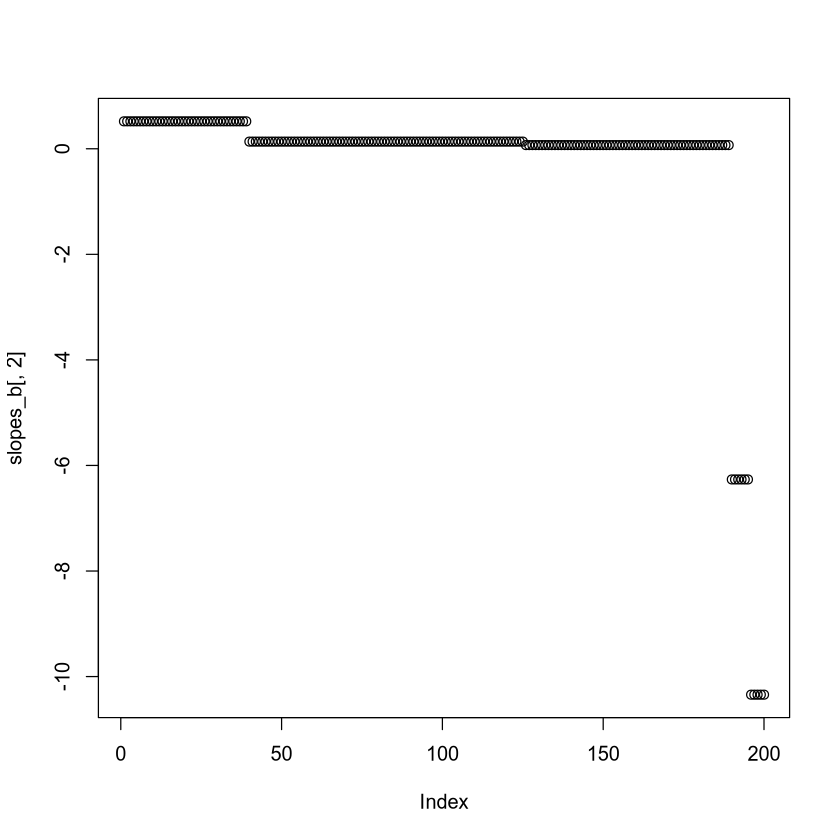

In [91]:
# K_inds[mask]
# plot(K_inds[mask,1])
# plot(K_inds[,2])
plot(slopes_b[,2])
# selection_indicators

In [85]:
# slopes_knotwise[K_inds[,1]] == slopes_b
c(1,2,3) * c(4,5,6)

[1]  4 10 18

In [57]:
ifelse(selection_indicators<0, c(1,num_knots)-1, c(1,num_knots))

0
5
0
6
1
6


In [102]:
tstmat <- matrix(c(1,1,2,2,3,3), nrow=3, ncol=2)
tstmat

which(tstmat == max(tstmat), arr.ind=TRUE)

1,2
1,3
2,3


row,col
2,2
3,2


In [105]:
expm(matrix(1, nrow=1, ncol=1))

2.718282


In [44]:
# print(mask)
# print(sum(mask))
# which(mask)
# print(size(t(W_guess[,1])))
# sample_sorting_indices <- my_oracle_estimator$sample_sorting_indices[[1]]
# print(sample_sorting_indices)
# tst <- SimData$pre_data[sample_sorting_indices,] %*% t(W_guess)
# plot(tst[,1])
# print(SimData$pre_data[sample_sorting_indices,])

Y_tst = matrix(0, nrow=d, ncol=d)
Y_tst[2,1] <- 1/sqrt(2)
Y_tst[1,2] <- -1/sqrt(2)
WY <- W_guess %*% Y_tst
sorted_samples <- SimData$pre_data[sample_sorting_indices,]
c_vec <- WY[1,]
sorted_samples[mask,] %*% c_vec



-0.4553930
-0.4202694
-0.2787045
0.3212857
0.3829043
0.3886912


In [74]:
tstdata <- c(4,2,5,7,1)
myres <- sort(W_guess[,2], index.return=TRUE)
print(myres)

$x
[1] -0.6064654  0.7951099

$ix
[1] 2 1



In [13]:
tstdata <- c(1,2,3,4,5,6,7,8)

my_arr <- array(data=tstdata, dim=c(2,2,2))
print(my_arr)

, , 1

     [,1] [,2]
[1,]    1    3
[2,]    2    4

, , 2

     [,1] [,2]
[1,]    5    7
[2,]    6    8



In [12]:
my_arr <- array(data=my_arr, dim=8)
print(my_arr)

[1] 1 2 3 4 5 6 7 8


In [25]:
# print(c(my_arr))
3^2

[1] 9

In [28]:
# diag(4)
print(tstdata %x% tstdata)

tstdata %x% tstdata == c(tstdata %o% tstdata)

 [1]  1  2  3  4  5  6  7  8  2  4  6  8 10 12 14 16  3  6  9 12 15 18 21 24  4
[26]  8 12 16 20 24 28 32  5 10 15 20 25 30 35 40  6 12 18 24 30 36 42 48  7 14
[51] 21 28 35 42 49 56  8 16 24 32 40 48 56 64


[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[16] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[31] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[46] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[61] TRUE TRUE TRUE TRUE

In [13]:
e1 <- c(1,0,0)
e2 <- c(0,1,0)
e3 <- c(0,0,1)

my_arr <- tensor(e1, e2, NULL, NULL)
my_arr <- tensor(my_arr, e3, NULL, NULL)
print(my_arr)

, , 1

     [,1] [,2] [,3]
[1,]    0    0    0
[2,]    0    0    0
[3,]    0    0    0

, , 2

     [,1] [,2] [,3]
[1,]    0    0    0
[2,]    0    0    0
[3,]    0    0    0

, , 3

     [,1] [,2] [,3]
[1,]    0    1    0
[2,]    0    0    0
[3,]    0    0    0



# Implement Auddy and Yuan (2023)

In [89]:
compute_Mhat <- function(data_mat) {

    n_here <- NROW(data_mat)
    d <- NCOL(data_mat)

    Idmat_vec <- c(diag(d))

    Y_mat <- t(apply(data_mat, MARGIN=1, function(myvec) kronecker(myvec, myvec)))
    Y_bar <- colMeans(Y_mat)
    Y_mat_centered <- t(t(Y_mat) - Y_bar)

    Mhat <- Idmat_vec %o% Idmat_vec

    for (nind in 1:n_here) {
        Mhat <- Mhat + (1/n_here) * (Y_mat_centered[nind,] %o% Y_mat_centered[nind,]) 
    }

    return(Mhat)
}

compute_M0_matricized <- function(d) {

    all_multiindices <- data.matrix(expand.grid(c(1:d), c(1:d), c(1:d), c(1:d)))
    
    num_uniq_indices <- apply(all_multiindices, MARGIN=1, function(v) length(unique(v)))
    
    M0 <- array(0, dim=c(d,d,d,d))
    M0[num_uniq_indices <= 2] = 1

    M0_matricized <- matrix(data=M0, nrow=d^2, ncol=d^2)

    return(M0_matricized)
}

compute_Phat <- function(Mhat, M0_matricized, d) {
    
    eigres <- eigs_sym(Mhat - M0_matricized, k=d, which="LM")
    eigvecs <- eigres$vectors
    eigvecs <- apply(eigvecs, MARGIN=2, function(v) v/sqrt(sum(v*v))) # normalize columns
    Phat <- eigvecs %*% t(eigvecs)

    return(Phat)
}

initialize_FastICA <- function(data_mat, M0_matricized, L_numiter) {

    n <- NROW(data_mat)
    d <- NCOL(data_mat)
    # Divide the samples
    num_samples_1 <- floor(0.5 * n)
    num_samples_2 <- n - num_samples_1

    data_mat <- data_mat[sample(n),]
    # randomized_centered_data <- center_data_fun(SimData$pre_data[sample(SimData$n),])
    data_1 <- data_mat[1:num_samples_1,]
    data_2 <- data_mat[(num_samples_1+1):n,]

    # Compute M1hat, M2hat, Phat
    M1hat <- compute_Mhat(data_1)
    M2hat <- compute_Mhat(data_2)
    Phat <- compute_Phat(M2hat, M0_matricized, d)

    # Compute scriptMhat - M0

    scriptMhat_centered_matricized <- Phat %*% (M1hat - M0_matricized) %*% Phat
    scriptMhat_centered <- array(data=scriptMhat_centered_matricized, dim=c(d,d,d,d))

    # Loop

    stored_u <- matrix(0, nrow=L_numiter, ncol=d)
    stored_sig <- rep(0, L_numiter)

    for (lind in 1:L_numiter) {
        G_mat <- matrix(data=rnorm(d^2), nrow=d, ncol=d)
        prod_mat <- tensor(scriptMhat_centered, G_mat, 3:4, 1:2)

        svdres <- svds(prod_mat, k=1, nu=1, nv=0)
        stored_sig[lind] <- svdres$d
        stored_u[lind,] <- svdres$u[,1]

    }

    L_star <- which(stored_sig == max(stored_sig))[1]

    return(stored_u[L_star,])

}

In [183]:
FastICA_Auddy_Yuan <- function(data_mat, T_numiter, L_numiter) {
    
    n <- NROW(data_mat)
    d <- NCOL(data_mat)

    W_hat <- matrix(0, nrow=d, ncol=d)
    M0_matricized <- compute_M0_matricized(d)

    for (dind in 1:d) {
        print("Initializing")
        ahat <- initialize_FastICA(data_mat, M0_matricized, L_numiter)

        print("Fixed-point iterations")
        for (tind in 1:T_numiter) {
            ahat_prev <- ahat
            ahat <- ahat - (1/(3*n))*c(t(data_mat) %*% ((data_mat %*% ahat)^3)) # The "c" only squeezes to a vector!
            ahat <- ahat / sqrt(sum(ahat*ahat))
            # print(sqrt(sum((ahat - ahat_prev)^2)))
        }
        W_hat[dind,] <- ahat
        
        # Deflation
        # print(size(ahat))
        data_mat <- data_mat - data_mat %*% (ahat %o% ahat)
        # print(max(abs(data_mat %*% ahat)))
    }

    return(W_hat)

}

[1] "Initializing"
[1] "Fixed-point iterations"
[1] "Initializing"
[1] "Fixed-point iterations"
[1] "Initializing"
[1] "Fixed-point iterations"
[1] "Initializing"
[1] "Fixed-point iterations"
[1] "Initializing"
[1] "Fixed-point iterations"
[1] "Initializing"
[1] "Fixed-point iterations"
[1] "Initializing"
[1] "Fixed-point iterations"
[1] "Initializing"
[1] "Fixed-point iterations"


-0.12562538,-0.07457117,0.012910751,-0.2290981,0.12942873,0.12476377,-0.26385333,-0.9077821
-0.23631121,-0.01216270,-0.028971335,-0.3951414,0.15396387,-0.05102850,-0.20389106,-0.8480287
0.25777465,0.29147729,0.017090818,0.4172504,-0.07785632,0.10214279,0.33637238,0.7379445
-0.20101533,-0.29805348,-0.145851820,-0.4865110,-0.06021044,-0.00959991,-0.19546077,-0.7555586
-0.03774127,-0.42568485,0.005412643,-0.4772417,-0.14336872,-0.01156510,-0.13026255,-0.7429148
0.07464990,-0.38663515,0.139194309,-0.4455362,-0.22161705,0.01602435,0.02090634,-0.7597731
0.11728278,-0.12199794,0.170962801,-0.4003305,-0.21661333,0.00904913,-0.13561975,-0.8464470
0.04372728,-0.43834231,0.163663853,-0.3123818,-0.06790948,-0.02935006,-0.16011730,-0.8065141


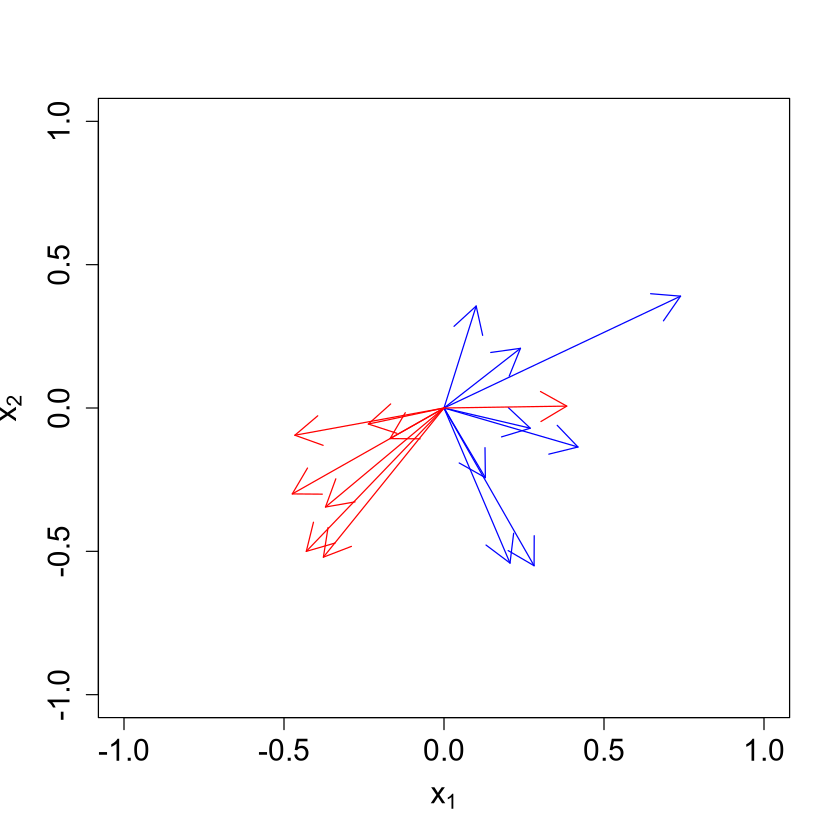

In [187]:
T_numiter <- 50
L_numiter <- 100
W_hat_test <- FastICA_Auddy_Yuan(SimData$pre_data, T_numiter, L_numiter)

visualize_independent_directions_from_W(SimData$W, W_hat_test)


In [188]:
W_hat_test %*% t(W_hat_test)

1.0000000,0.9579292,-0.9054684,0.8855194,0.8346662,0.7808304,0.8655522,0.8628089
0.9579292,1.0000000,-0.9414089,0.9194012,0.8376063,0.7641871,0.8386533,0.8213273
-0.9054684,-0.9414089,1.0000000,-0.9637829,-0.9149087,-0.8117207,-0.8219039,-0.8907717
0.8855194,0.9194012,-0.9637829,1.0000000,0.9613776,0.8798453,0.8616204,0.8950021
0.8346662,0.8376063,-0.9149087,0.9613776,1.0000000,0.9684602,0.9169412,0.9650169
0.7808304,0.7641871,-0.8117207,0.8798453,0.9684602,1.0000000,0.9465052,0.9587011
0.8655522,0.8386533,-0.8219039,0.8616204,0.9169412,0.9465052,1.0000000,0.9304727
0.8628089,0.8213273,-0.8907717,0.8950021,0.9650169,0.9587011,0.9304727,1.0000000


In [161]:
data_mat <- SimData$pre_data
# c(data_mat %*% u_star)
c(t(data_mat) %*% ((data_mat %*% u_star)^3))

[1] -70.13994 -90.07492 -50.32590

In [83]:
M0_matricized <- compute_M0_matricized(d)

In [142]:
L_numiter <- 50
u_star <- initialize_FastICA(SimData$pre_data, M0_matricized, L_numiter)
u_star

SimData$W %*% u_star

[1] -0.6253866 -0.7189229 -0.3033833

-0.3210550
-0.8485210
0.4206374


In [147]:
u_star %o% u_star

0.3911084,0.4496048,0.18973188
0.4496048,0.5168501,0.21810922
0.1897319,0.2181092,0.09204144


In [29]:
## Algorithm 2

# Divide the samples
num_samples_1 <- floor(0.5 * SimData$n)
num_samples_2 <- SimData$n - num_samples_1
# randomized_centered_data <- center_data_fun(SimData$pre_data[sample(SimData$n),])
data_1 <- SimData$pre_data[1:num_samples_1,]
data_2 <- SimData$pre_data[(num_samples_1+1):SimData$n,]

M1hat <- compute_Mhat(data_1)
M1hat

1.14377725,-0.01552338,-0.01402736,-0.01552338,0.95699537,0.01210662,-0.01402736,0.01210662,0.96567262
-0.01552338,0.06949666,0.01019879,0.06949666,-0.01578707,0.01542151,0.01019879,0.01542151,0.02204116
-0.01402736,0.01019879,0.06622918,0.01019879,0.02148261,0.02438791,0.06622918,0.02438791,-0.01196231
-0.01552338,0.06949666,0.01019879,0.06949666,-0.01578707,0.01542151,0.01019879,0.01542151,0.02204116
0.95699537,-0.01578707,0.02148261,-0.01578707,1.20202045,-0.01235860,0.02148261,-0.01235860,0.95456896
0.01210662,0.01542151,0.02438791,0.01542151,-0.01235860,0.07533029,0.02438791,0.07533029,-0.01098911
-0.01402736,0.01019879,0.06622918,0.01019879,0.02148261,0.02438791,0.06622918,0.02438791,-0.01196231
0.01210662,0.01542151,0.02438791,0.01542151,-0.01235860,0.07533029,0.02438791,0.07533029,-0.01098911
0.96567262,0.02204116,-0.01196231,0.02204116,0.95456896,-0.01098911,-0.01196231,-0.01098911,1.17416738


In [25]:
Y_mat <- t(apply(data_1, MARGIN=1, function(myvec) kronecker(myvec, myvec)))
Y_bar <- colMeans(Y_mat)
Y_mat_centered <- t(t(Y_mat) - Y_bar)


ERROR: Error in eval(expr, envir, enclos): object 'data_1' not found


In [24]:
# Y_mat_centered
tst <- expand.grid(c(1,2,3), c(1,2,3), c(1,2,3))

# print(data.matrix(tst)[1,])
# unique(data.matrix(tst)[1,])
print(apply(data.matrix(tst), MARGIN=1, function(v) length(unique(v))))

 [1] 1 2 2 2 2 3 2 3 2 2 2 3 2 1 2 3 2 2 2 3 2 3 2 2 2 2 1


In [41]:
# tst <- asplit(data_1, MARGIN=1)
tst <- t(apply(data_1, MARGIN=1, function(myvec) kronecker(myvec, myvec)))
print(size(tst))
# print(tst)
print(colMeans(tst))

[1] 250   9
[1]  0.329905764  0.015765226 -0.001892759  0.015765226  0.334731763
[6] -0.001342564 -0.001892759 -0.001342564  0.318050992


In [32]:
M1hat

1.14377725,-0.01552338,-0.01402736,-0.01552338,0.95699537,0.01210662,-0.01402736,0.01210662,0.96567262
-0.01552338,0.06949666,0.01019879,0.06949666,-0.01578707,0.01542151,0.01019879,0.01542151,0.02204116
-0.01402736,0.01019879,0.06622918,0.01019879,0.02148261,0.02438791,0.06622918,0.02438791,-0.01196231
-0.01552338,0.06949666,0.01019879,0.06949666,-0.01578707,0.01542151,0.01019879,0.01542151,0.02204116
0.95699537,-0.01578707,0.02148261,-0.01578707,1.20202045,-0.01235860,0.02148261,-0.01235860,0.95456896
0.01210662,0.01542151,0.02438791,0.01542151,-0.01235860,0.07533029,0.02438791,0.07533029,-0.01098911
-0.01402736,0.01019879,0.06622918,0.01019879,0.02148261,0.02438791,0.06622918,0.02438791,-0.01196231
0.01210662,0.01542151,0.02438791,0.01542151,-0.01235860,0.07533029,0.02438791,0.07533029,-0.01098911
0.96567262,0.02204116,-0.01196231,0.02204116,0.95456896,-0.01098911,-0.01196231,-0.01098911,1.17416738


In [62]:
# print(M1hat[M1hat<0])
# print(array(0, dim=c(2,2,2,3)))
# print(size(compute_M0(3)))
tst <- matrix(data=compute_M0(3), nrow=9, ncol=9)
tst == t(tst)

TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE


In [70]:
# ch <- eigs_sym(tst, k=3)
ch <- svds(tst, k=1, nu=1, nv=0)
ch

-0.4423569
-0.2623487
-0.2623487
-0.2623487
-0.4423569
-0.2623487
-0.2623487
-0.2623487
-0.4423569


In [58]:
# t(ch$vectors) %*% ch$vectors
ch$vectors

-0.4423569,-0.35783969,-0.1132872
-0.2623487,-0.37842930,0.3459523
-0.2623487,-0.11038881,-0.5007055
-0.2623487,-0.37842930,0.3459523
-0.4423569,0.08081022,0.3665419
-0.2623487,0.48881811,0.1547532
-0.2623487,-0.11038881,-0.5007055
-0.2623487,0.48881811,0.1547532
-0.4423569,0.27702947,-0.2532546


In [59]:
ch2 <- apply(ch$vectors, MARGIN=2, function(v) v/sqrt(sum(v*v)))
ch2
# t(ch2) %*% ch2

-0.4423569,-0.35783969,-0.1132872
-0.2623487,-0.37842930,0.3459523
-0.2623487,-0.11038881,-0.5007055
-0.2623487,-0.37842930,0.3459523
-0.4423569,0.08081022,0.3665419
-0.2623487,0.48881811,0.1547532
-0.2623487,-0.11038881,-0.5007055
-0.2623487,0.48881811,0.1547532
-0.4423569,0.27702947,-0.2532546


In [79]:
# matrix(data=rnorm(d^2), nrow=d, ncol=d)
# rep(0,4)
ch <- which(c(2,4,3,3) == max(c(2,4,3,3)))
ch[1]

[1] 2

In [162]:
mymat <- matrix(c(1,2,3,4), nrow=2, ncol=2)
mymat %*% c(1,1)

4
6
